In [1]:
import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex

from neural_dice_v2 import SquaredActivation, ValueNetwork, NeuralDice
from policy import RandomPolicy, PopularRandomPolicy
from data import MovieLensBasicMDP, transform_indices, CartPoleMDP

%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 12
DEVICE = torch.device('cpu')
BATCH_SIZE = 8
NUM_SAMPLES = 1024
NUM_ITER = 200000
EVAL_ITER = 100

ZETA_POS = False # squared output of zeta(s,a)                  (used in GenDICE, BestDice)
ZERO_REWARD = True # whether include the reward in loss or not (used in MQL, BestDICE)
NORM_REGULARIZER = 0.0 # use lambda or not                      (used in GenDICE, GradientDICE, BestDICE)
PRIMAL_REGULARIZER = 0.0 # alpha_Q                              (used in GenDICE, GradientDICE)
DUAL_REGULARIZER = 1.0 # alpha_zeta                             (used in DualDICE, BestDICE)

NU_LR = 0.0001
ZETA_LR = 0.0001
GAMMA = 0.99

In [3]:
def custom_collate(data_list):
    first_state = []
    current_state = []
    current_action = []
    next_state = []
    rewards = []
    step_num = []

    for fs, cs, ca, ns, rw, sn in data_list:
        first_state.append(fs)
        current_state.append(cs)
        current_action.append(ca)
        next_state.append(ns)
        rewards.append(rw)
        step_num.append(sn)

    return (
        torch.concat(first_state, dim=0),
        torch.concat(current_state, dim=0),
        torch.concat(current_action, dim=0),
        torch.concat(next_state, dim=0),
        torch.concat(rewards, dim=0),
        torch.concat(step_num, dim=0)
    )

loader_generator = torch.Generator()
loader_generator.manual_seed(RANDOM_SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed+worker_id)

dataset = CartPoleMDP(
    ds_path="/home/hdilab/amgimranov/Dice-RL/cartpole_ds.npy",
    num_samples=NUM_SAMPLES
)

loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=custom_collate,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=loader_generator
)

In [4]:
from cartpole import RandomPolicy

policy = RandomPolicy(
    device=DEVICE,
    name='RandomPolicy',
)

In [ ]:
nu = ValueNetwork(
    num_layers=2,
    state_dim=4,
    action_dim=2,
    hidden_dim=64,
    # output_activation="tanh",
    output_activation=None,
    seed=RANDOM_SEED
)
nu = nu.to(DEVICE)

zeta = ValueNetwork(
    num_layers=2,
    state_dim=4,
    action_dim=2,
    hidden_dim=64,
    output_activation=SquaredActivation if ZETA_POS else None,
    seed=RANDOM_SEED+1
)
zeta = zeta.to(DEVICE)

dice = NeuralDice(
    nu_network=nu,
    zeta_network=zeta,
    nu_lr=NU_LR,
    zeta_lr=ZETA_LR,
    lambda_lr=NU_LR,
    num_actions=2,
    gamma=GAMMA,
    zero_reward=ZERO_REWARD,
    f_exponent=2,
    primal_form=False,
    num_action_samples=None, # number of action samples used in Q expectation
    primal_regularizer=PRIMAL_REGULARIZER,
    dual_regularizer=DUAL_REGULARIZER,
    norm_regularizer=NORM_REGULARIZER,
    nu_regularizer=0.0, # nu network regularizer
    zeta_regularizer=0.0, # zeta network regularizer
    weight_by_gamma=False, # weight loss by gamma**step_num
    device=DEVICE
)

In [6]:
def estimate_policy(data: MovieLensBasicMDP, print_zeta=False):
    values = []
    for batch in data.iterate_dataset(batch_size=100):
        batch = [b.to(DEVICE) for b in batch]
        states, actions, rewards = batch

        values.append(
            dice.estimate_average_reward(
                states=states,
                actions=actions,
                rewards=rewards,
                print_zeta=print_zeta
            )
        )
        print_zeta=False

    return np.mean(values)

In [7]:
def plot_info(nu_losses, zeta_losses, values):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.plot(nu_losses)
    plt.title('nu loss')

    plt.subplot(1, 3, 2)
    plt.plot(zeta_losses)
    plt.title('zeta loss')

    plt.subplot(1, 3, 3)
    plt.plot(values)
    plt.title('values')

    plt.show()

In [8]:
from tqdm import tqdm
from IPython.display import clear_output

def calc_grad(model):
    return np.sqrt(sum([torch.norm(p.grad)**2 for p in model.parameters()]))


# nu_losses = []
# zeta_losses = []
# lambda_losses = []
losses = []
values = []

for i, batch in enumerate(tqdm(loader, total=NUM_ITER)):
    if i >= NUM_ITER:
        break

    batch = [b.to(DEVICE) for b in batch]

    loss = dice.train_batch(batch=batch, policy=policy)
    losses.append(loss)
    # nu_losses.append(nu_loss)
    # zeta_losses.append(zeta_loss)
    # lambda_losses.append(lambda_loss)

    if i % EVAL_ITER  == 0 or i == (NUM_ITER - 1):
        clear_output()
        value = estimate_policy(data=dataset, print_zeta=True)
        values.append(value)
        print(f'Value on iteration {i}: {value}. Loss: {loss}')
        print("nu grad:", calc_grad(nu))
        print("zeta grad:", calc_grad(zeta))
        # plot_info(nu_losses, zeta_losses, values)

tensor(0.0455) tensor(-0.2447) tensor(0.3479)


  0%|          | 405/200000 [00:14<3:14:03, 17.14it/s]

Value on iteration 400: -0.09687058587706997. Loss: -0.1615668088197708
nu grad: tensor(1.0000)
zeta grad: tensor(1.0000)


  0%|          | 429/200000 [00:15<1:58:57, 27.96it/s]


KeyboardInterrupt: 

In [3]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

values = np.load("/home/hdilab/amgimranov/Dice-RL/experiments/base_exp/values.npy")
plt.plot(moving_average(np.array(values), n=10))
from pathlib import Path
exp_folder = Path("/home/hdilab/amgimranov/Dice-RL/experiments/base_exp")
plt.savefig(exp_folder / "values.png", dpi=300, bbox_inches="tight")
plt.close()

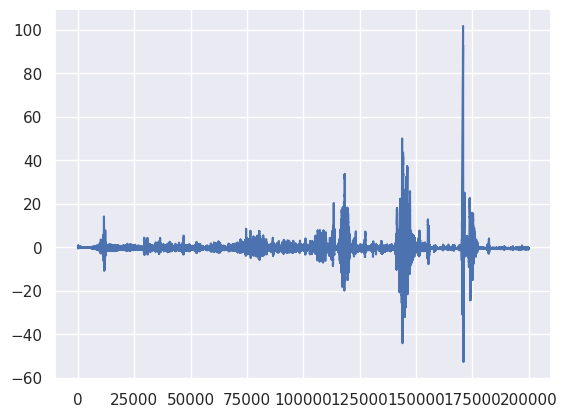

In [10]:
losses = np.load("/home/hdilab/amgimranov/Dice-RL/losses.npy")
plt.plot(np.array(losses))

* несколько седловых точек
* можно попробовать агрессивно уменьшать `lr`
* большой батч не помогает, из-за него можем застревать в седловых точках

In [ ]:
for batch in tqdm(loader, total=)

plt.hist(zeta(next(iter(loader))[0])[:, 0].detach().numpy(), bins=100)

SyntaxError: invalid syntax (328501664.py, line 1)

(array([ 6.,  9.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  9.,  7., 12., 15.,
        12., 11., 19., 39., 15.,  6., 17., 19.,  4., 43.,  5., 21., 48.,
        22., 16., 13., 37., 41., 32., 28., 29., 41., 31., 52., 20., 22.,
        14.,  9., 30., 29., 35., 48., 54., 31., 27., 37., 37., 15., 40.,
        55., 37., 24., 40., 20., 25., 31., 24., 31., 18., 34., 22., 20.,
        23., 32., 38., 14., 45., 12., 31.,  8., 12., 15., 13., 31., 19.,
        26., 14.,  9.,  7., 24., 17.,  0., 35.,  6.,  0., 14.,  0.,  0.,
        26.,  3., 18.,  8.,  2., 27.,  9.,  0., 14.]),
 array([1.57688129, 1.57749426, 1.57810724, 1.57872021, 1.57933319,
        1.57994628, 1.58055925, 1.58117223, 1.5817852 , 1.58239818,
        1.58301115, 1.58362412, 1.5842371 , 1.58485007, 1.58546305,
        1.58607602, 1.58668911, 1.58730209, 1.58791506, 1.58852804,
        1.58914101, 1.58975399, 1.59036696, 1.59097993, 1.59159291,
        1.592206  , 1.59281898, 1.59343195, 1.59404492, 1.5946579 ,
        1.59527087, 1.5958

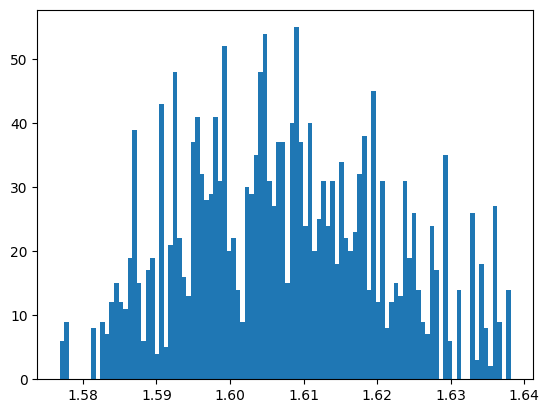

In [ ]:
plt.hist(zeta(next(iter(loader))[0])[:, 1].detach().numpy(), bins=100)

In [ ]:
weights = []
for batch in tqloader:
    weights.append(zeta(batch[0]).flatten())

KeyboardInterrupt: 

In [ ]:
zeta

ValueNetwork(
  (_network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
assert False

AssertionError: 

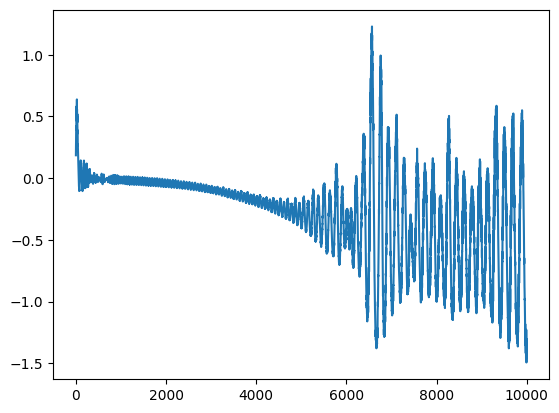

In [ ]:
plt.plot(losses)

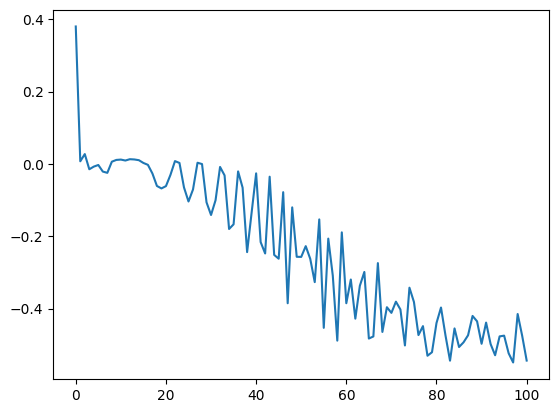

In [ ]:
plt.plot(values)

In [ ]:
np.mean(values[-10:])

-0.49244184727220713

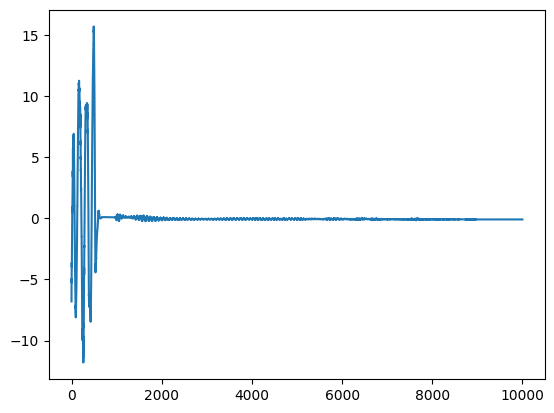

In [ ]:
plt.plot(losses)

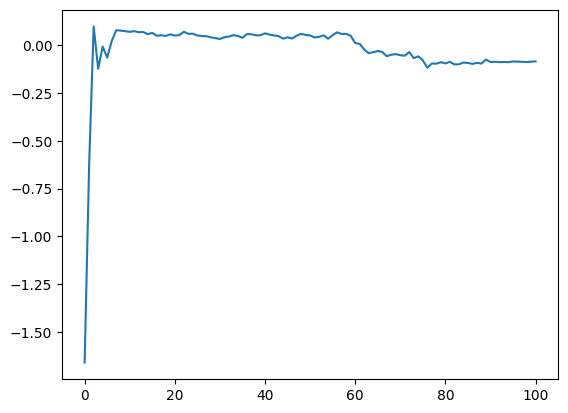

In [ ]:
plt.plot(values)

* проверить правильно ли написан CartPole
* еще раз посмотреть знаки + в целом логику лосса (можно переписать через одно число)
* проверить opt.step() и backward()
* логгировать градиенты
* зафиксировать nu и посмотреть сходимость по zeta. она должна выучиваться, если ее нет, то что-то не так с градиентами
* посмотреть выходы zeta
* zero_reward
* понять что мы получаем p или p_hat
* понять что мы хотим получить

In [ ]:
values[-10:]

[-0.08531219966912613,
 -0.08754067492991453,
 -0.08640308041946264,
 -0.08754793433312442,
 -0.08396263449802063,
 -0.08475542239788046,
 -0.08560998491267674,
 -0.08726074809581041,
 -0.08488217813396477,
 -0.08371280789555749]